# Set global parameters


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates how to set global parameters of the library.


## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## View global parameters

The OptimUS library uses default settings in a variety of routines. The global parameters can be viewed and changed in the ```optimus.global_parameters``` class instance.

In [4]:
optimus.global_parameters.print()

Verbosity: False

Linear algebra.
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Preconditioning.

 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None


Additionally, the global parameters of the BEMPP library (which is heavily used by OptimUS), can be retrieved as ```optimus.global_parameters.bempp_parameters```.

In [5]:
print("The assembly type used by BEMPP is:",
      optimus.global_parameters.bempp_parameters.assembly.boundary_operator_assembly_type)

The assembly type used by BEMPP is: hmat


## Specify the wave model

Let us consider a standard test case of a spherical bone embedded in water, excited by a plane wave, and solved by a standard BEM model.

In [6]:
source = optimus.source.create_planewave(frequency=1000)
geometry = optimus.geometry.shapes.Sphere(h=0.4)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

In [7]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

## Simulate the wave model with different global parameters for the linear solver

The BEM model is solved with the GMRES algorithm. As an iterative linear solver, one can specify the tolerance and the maximum number of iterations. Let us solve the model with the default model and then change the settings.

In [8]:
model.solve()

In [9]:
print("The global parameters for the linear algebra are as follows.")
print("")
optimus.global_parameters.linalg.print()
print("")
print("The model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Tolerance: 1e-05
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 25 iterations.


Let us change the tolerance of the GMRES algorithm. Generally speaking, a smaller tolerance gives a more accurate approximation to the surface potentials but requires more iterations from the linear solver.

In [10]:
optimus.global_parameters.linalg.tol = 1e-9

In [11]:
model.solve()

In [12]:
print("The global parameters for the linear algebra are as follows.")
print("")
optimus.global_parameters.linalg.print()
print("")
print("The model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Tolerance: 1e-09
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 36 iterations.


Let us change the maximum number of iterations that can be used by GMRES. A smaller value limits the simulation time of the linear solver. However, if this maximum is reached, the solution might not be accurate since the final estimate has a larger residual than the specified tolerance.

In [13]:
optimus.global_parameters.linalg.maxiter = 10

In [14]:
model.solve()

../optimus/model/linalg.py:85: RuntimeWarning: The GMRES solver stopped at the maximum number of 10 iterations.
  RuntimeWarning,


In [15]:
print("The global parameters for the linear algebra are as follows.")
print("")
optimus.global_parameters.linalg.print()
print("")
print("The model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Tolerance: 1e-09
Maximum number of iterations: 10
Number of iterations before restart: 1000

The model was solved in 10 iterations.


## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [16]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [17]:
# Create a visualisation grid
Nx = 100
Ny = 100
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > 1.0
idx_int = np.logical_not(idx_ext)
points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

In [18]:
# Calculate the fields from the surface potential with the potential operators
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext, surfpot_neu_ext = model.solution
surfpot_dir_int = surfpot_dir_ext
surfpot_neu_int = (material_int.density / material_ext.density) * surfpot_neu_ext
total_field_int = (slp_pot_int * surfpot_neu_int
                   - dlp_pot_int * surfpot_dir_int).ravel()
total_field_ext = (dlp_pot_ext * surfpot_dir_ext 
                   - slp_pot_ext * surfpot_neu_ext).ravel() \
    + np.exp(1j * material_ext.compute_wavenumber(source.frequency) * points_exterior[0])

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int
total_field = total_field.reshape([Nx, Ny])

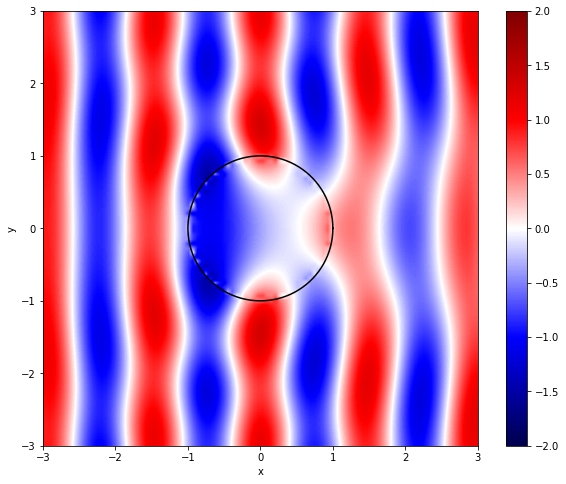

In [19]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(np.flipud(total_field.T)), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()